In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace,when
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .appName("Sales Data Analysis") \
    .getOrCreate()

# Step 2: Load the dataset
print("Start reading file sales_data.csv")
file_path = "/home/jovyan/work/sales_data.csv"
sales_data = spark.read.csv(file_path, header=True, sep=';',inferSchema=True)

sales_data.show()


+-------------+---------+--------+---------+-------------+
|TransactionID|ProductID|Quantity|SalePrice|PurchasePrice|
+-------------+---------+--------+---------+-------------+
|            1|     1124|       5|    13.38|         9.91|
|            2|     1146|      14|    26.88|         25.6|
|            3|     1128|       8|    15.89|        13.24|
|            4|     1101|       8|      2.9|         2.42|
|            5|     1112|       2|     7.23|         4.82|
|            6|     1133|      12|    17.21|        16.39|
|            7|     1110|      10|     9.83|         8.94|
|            8|     1105|       3|     4.29|         2.96|
|            9|     1124|       2|    14.87|         9.91|
|           10|     1125|       9|     17.8|        14.83|
|           11|     1122|       1|    20.41|        13.17|
|           12|     1148|      12|     3.14|         2.99|
|           13|     1134|      21|    21.18|        20.17|
|           14|     1115|       9|     7.73|         6.7

In [3]:

def replace_empty_with_zero(df):
    for column in df.columns:
        # Replace empty cells with "0" using 'when' function
        df = df.withColumn(column, when(col(column).isNull(), 0).otherwise(col(column)))
    return df


# Define the function to remove "-" from SalesPrice and PurchasePrice columns
def remove_minus_sign(df):

    # Remove "-" and cast to float using 'when' function
    df = df.withColumn("SalePrice", regexp_replace(col("SalePrice"), "-", "").cast(FloatType()))
    df = df.withColumn("PurchasePrice",regexp_replace(col("PurchasePrice"), "-", "").cast(FloatType()))
    return df


# Define the function to handle outliers in the quantity column
def handle_quantity_outliers(df, max_quantity_threshold):
    # Cap the Quantity column at a maximum threshold
    df = df.withColumn("Quantity", when(col("Quantity") > max_quantity_threshold, max_quantity_threshold).otherwise(
        col("Quantity")))
    return df


# Define the function to validate data types of columns
def validate_data_types(df):
    expected_data_types = {
        "TransactionID": "IntegerType()",
        "ProductID": "IntegerType()",
        "Quantity": "IntegerType()",
        "SalePrice": "FloatType()",
        "PurchasePrice": "FloatType()"
    }

    for column, data_type in expected_data_types.items():
        # Check if the actual data type matches the expected data type
        actual_data_type = str(df.schema[column].dataType)
        if actual_data_type != data_type:
            print(f"Invalid data type for column '{column}'. Expected: {data_type}, Actual: {actual_data_type}")
            return False
    return True



sales_data.printSchema()

root
 |-- TransactionID: integer (nullable = true)
 |-- ProductID: integer (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- SalePrice: string (nullable = true)
 |-- PurchasePrice: double (nullable = true)



In [4]:
print("Starting Datatype validation ")
valid_data_types = validate_data_types(sales_data)
if valid_data_types:
    print("Data types are valid.")
else:
    print("Data types are not valid.")

# Replace empty cells with "0"
print("Handling Blanks")
sales_data = replace_empty_with_zero(sales_data)
print("Handling Special Characters")
# Remove "-" from SalesPrice and PurchasePrice columns
sales_data = remove_minus_sign(sales_data)
print("Handling Outliers")
# Handle outliers in the quantity column
sales_data = handle_quantity_outliers(sales_data, max_quantity_threshold=250)
print("Removing Duplicates")
# Remove duplicates
print("Number of duplicate rows: {}".format(sales_data.dropDuplicates().count()))
sales_data = sales_data.dropDuplicates()

# Convert PySpark DataFrame to Pandas DataFrame
sales_pandas = sales_data.toPandas()
sales_pandas['TransactionID'] = sales_pandas['TransactionID'].fillna(0).astype('int32')
sales_pandas['ProductID'] = sales_pandas['ProductID'].fillna(0).astype('int32')
sales_pandas['Quantity'] = sales_pandas['Quantity'].fillna(0).astype('int32')
sales_pandas['SalePrice'] = sales_pandas['SalePrice'].fillna(0.00).astype('float32')
sales_pandas['PurchasePrice'] = sales_pandas['PurchasePrice'].fillna(0.00).astype('float32')

# Save Pandas DataFrame to CSV file
print("writing the data to the cleaned csv")
file_path = "sales_data_cleaned.csv"
sales_pandas.to_csv(file_path, index=False)

Invalid data type for column 'SalePrice'. Expected: FloatType(), Actual: StringType()
Data types are not valid.
Number of duplicate rows: 2570
writing the data to the cleaned csv


Product-wise statistics:
+---------+------------------+------------------+
|ProductID|     avg(Quantity)|    avg(SalePrice)|
+---------+------------------+------------------+
|     1127| 7.777777777777778|15.831110954284668|
|     1143| 6.447368421052632|17.086052718915436|
|     1139|6.7631578947368425|31.710526315789473|
|     1133| 7.743589743589744|19.523076913295647|
|     1135|6.1568627450980395| 40.80588284660788|
|     1148|10.628571428571428| 3.514428622382028|
|     1125| 5.525252525252525|17.799999237060547|
|     1114|               5.6| 6.111999988555908|
|     1122| 5.636363636363637|17.360113653269682|
|     1145| 7.107142857142857|28.074464048658097|
|     1190|               5.0|              NULL|
|     1137|10.483870967741936|2.5233871167705906|
|     1100|             15.85|2.2516665975252788|
|     1130| 9.761904761904763| 33.93380955287388|
|     1144|              13.5| 4.438333352406819|
|     1113|               6.5|16.319999984332494|
|     1146|10.37931034482

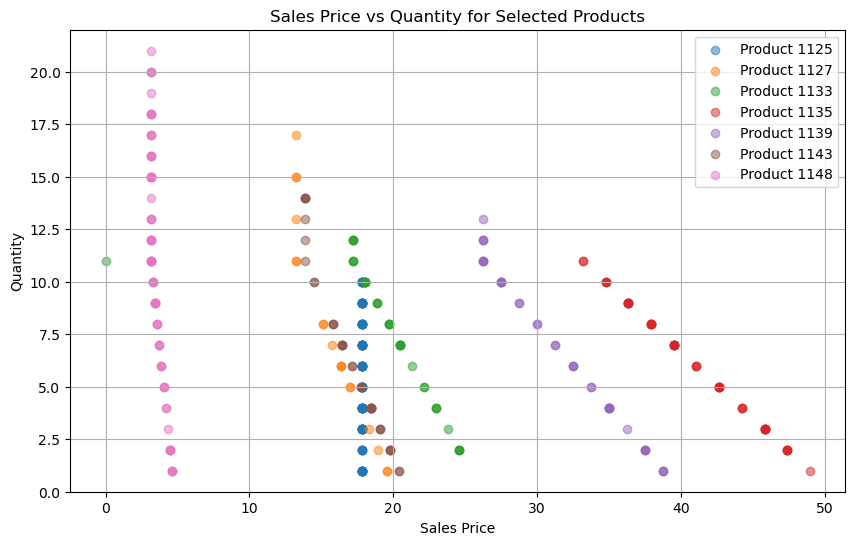

In [5]:
# Product-wise analysis
product_stats = sales_data.groupBy('ProductID').agg({'SalePrice': 'mean', 'Quantity': 'mean'})
print("Product-wise statistics:")
# Compute average SalePrice and Quantity for each ProductID
product_stats.show()

#few products as example for sales price vs quantity
product_ids = [1127,1143,1139,1133,1135,1148,1125]

filtered_data = sales_pandas[sales_pandas['ProductID'].isin(product_ids)]

# Visualization
plt.figure(figsize=(10, 6))
for product_id, group_data in filtered_data.groupby('ProductID'):
    plt.scatter(group_data['SalePrice'], group_data['Quantity'], label=f'Product {product_id}',alpha=0.5)

plt.xlabel('Sales Price')
plt.ylabel('Quantity')
plt.title('Sales Price vs Quantity for Selected Products')
plt.legend()
plt.grid(True)
plt.savefig('sales_price_vs_quantity_per_product.png')  # Save the line graph as an image